In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import yfinance as yf
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM,select_order, select_coint_rank
from statsmodels.regression.linear_model import OLS
from pykalman import KalmanFilter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.ensemble import IsolationForest
from scipy.stats import jarque_bera 
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


/Users/shubhamborda/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load the data from CSV.
sp500  = pd.read_csv('SP500.csv')
nq100 = pd.read_csv('NASDAQ100.csv')

In [3]:
# Rename 'Close/Last' to 'Close'
sp500.rename(columns={'Close/Last': 'Close'}, inplace=True)
nq100.rename(columns={'Close/Last': 'Close'}, inplace=True)

In [4]:
# Convert 'Date' column to datetime
sp500['Date'] = pd.to_datetime(sp500['Date'])
nq100['Date'] = pd.to_datetime(nq100['Date'])

In [5]:
# Set 'Date' as the index
sp500.set_index('Date', inplace=True)
nq100.set_index('Date', inplace=True)

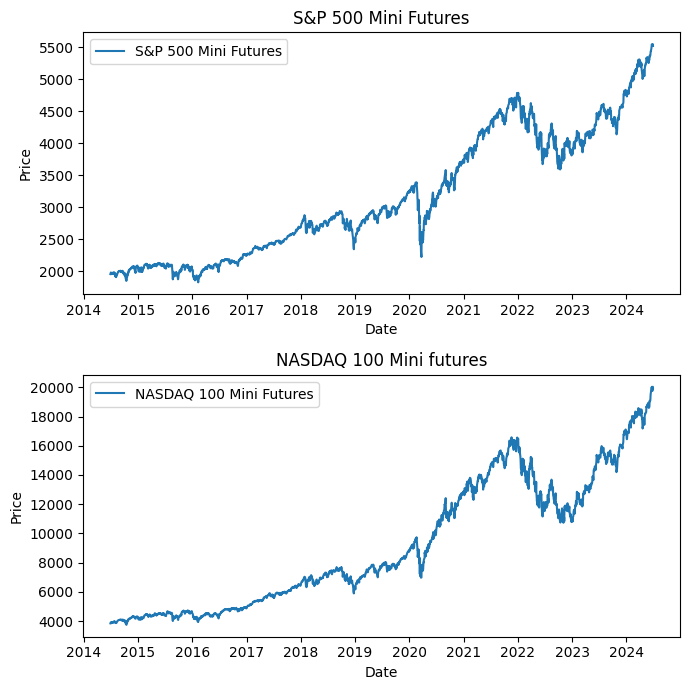

In [6]:
# Plot the data
plt.figure(figsize=(7,7))

plt.subplot(2, 1, 1)
plt.plot(sp500['Close'], label='S&P 500 Mini Futures')
plt.title('S&P 500 Mini Futures')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(nq100['Close'], label='NASDAQ 100 Mini Futures')
plt.title('NASDAQ 100 Mini futures')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Interactive Plot SP500 Mini Futures
fig_sp500 = go.Figure()
fig_sp500.add_trace(go.Scatter(x=sp500.index, y=sp500['Close'], mode='lines', name='SP500 Mini Futures'))
fig_sp500.update_layout(title='SP500 Mini Futures Time Series',
                        xaxis_title='Date',
                        yaxis_title='Price')
fig_sp500.show()

# Plot NASDAQ100
fig_nasdaq = go.Figure()
fig_nasdaq.add_trace(go.Scatter(x=nq100.index, y=nq100['Close'], mode='lines', name='NASDAQ100'))
fig_nasdaq.update_layout(title='NASDAQ100 Time Series',
                         xaxis_title='Date',
                         yaxis_title='Price')


In [8]:
# Function to perform ADF test and print the results
def adf_test(timeseries, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(timeseries, autolag='AIC',regression='ct')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')
    return result[1]
    

# # Perform ADF test on both indices
sp500_adf= adf_test(sp500['Close'], 'S&P 500 Mini Futures')
nq100_adf = adf_test(nq100['Close'], 'NASDAQ 100 mini futures')



Augmented Dickey-Fuller Test: S&P 500 Mini Futures
ADF Statistic             -3.217966
p-value                    0.080881
# Lags Used                9.000000
# Observations Used     2520.000000
Critical Value (1%)       -3.962367
Critical Value (5%)       -3.412234
Critical Value (10%)      -3.128077
dtype: float64

Augmented Dickey-Fuller Test: NASDAQ 100 mini futures
ADF Statistic             -2.272825
p-value                    0.449035
# Lags Used               25.000000
# Observations Used     2504.000000
Critical Value (1%)       -3.962390
Critical Value (5%)       -3.412245
Critical Value (10%)      -3.128083
dtype: float64



In [9]:
# Taking log of the series
sp500['Diff_Log_Close_SP500'] = np.log(sp500['Close'])
nq100['Diff_Log_Close_NQ100']=np.log(nq100['Close'])

# First difference of log-transformed series
sp500['Diff_Log_Close_SP500'] = sp500['Close'].diff().dropna()
nq100['Diff_Log_Close_NQ100'] = nq100['Close'].diff().dropna()

# Again performing the ADF test for Stationarity in the time Series
# Re-run ADF test on differenced data
sp500_diff_adf = adf_test(sp500['Diff_Log_Close_SP500'].dropna(), 'Differenced S&P 500')
nq100_diff_adf = adf_test(nq100['Diff_Log_Close_NQ100'].dropna(), 'Differenced NASDAQ 100')


Augmented Dickey-Fuller Test: Differenced S&P 500
ADF Statistic          -1.553203e+01
p-value                 1.363429e-22
# Lags Used             9.000000e+00
# Observations Used     2.519000e+03
Critical Value (1%)    -3.962368e+00
Critical Value (5%)    -3.412234e+00
Critical Value (10%)   -3.128077e+00
dtype: float64

Augmented Dickey-Fuller Test: Differenced NASDAQ 100
ADF Statistic          -1.095849e+01
p-value                 2.670337e-17
# Lags Used             2.400000e+01
# Observations Used     2.504000e+03
Critical Value (1%)    -3.962390e+00
Critical Value (5%)    -3.412245e+00
Critical Value (10%)   -3.128083e+00
dtype: float64



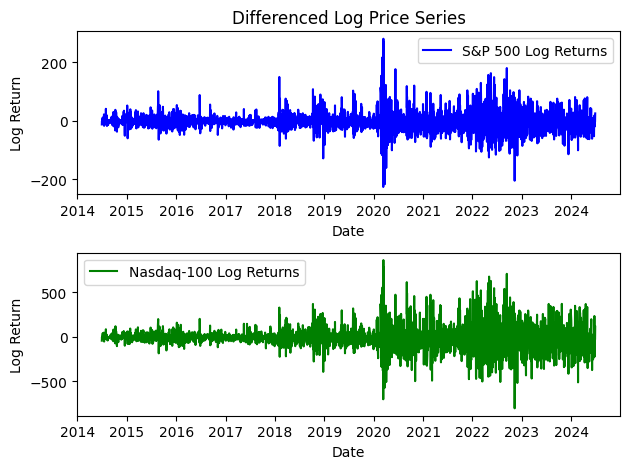

In [10]:
# Plot for S&P 500
plt.subplot(2, 1, 1)
plt.plot(sp500.index, sp500['Diff_Log_Close_SP500'], label='S&P 500 Log Returns', color='blue')
plt.title('Differenced Log Price Series')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()

# Plot for Nasdaq-100
plt.subplot(2, 1, 2)
plt.plot(nq100.index, nq100['Diff_Log_Close_NQ100'], label='Nasdaq-100 Log Returns', color='green')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Performing Engle and Granger approach for checking cointegration between two series

def engle_granger_cointegration(x, y):
    if sp500_diff_adf > 0.05 and nq100_diff_adf>0.05:
        print('Warning: One or both of the series are not stationary. We ensure that both the series are I(1)')
        return None
    results = {}

    # Aligning the indices of two series
    x,y  =x.align(y, join='inner')
    
     # Regressing y on x
    model_1 = OLS(y, x)
    result_1 = model_1.fit()
    residuals_1 = y - result_1.params[0] * x
    p_value_residuals_1 = adf_test(residuals_1, title='Residuals (y on x)')
    results['y_on_x'] = p_value_residuals_1

    #  Regressing x on y
    model_2 = OLS(x,y)
    result_2 = model_2.fit()
    residuals_2 = x -result_2.params[0]*y
    p_value_residuals_2 = adf_test(residuals_2,title = 'Residuals (x on y)')
    results['x_on_y'] = p_value_residuals_2

    return results

p_values = engle_granger_cointegration(sp500['Diff_Log_Close_SP500'].dropna(),nq100['Diff_Log_Close_NQ100'].dropna())


Augmented Dickey-Fuller Test: Residuals (y on x)
ADF Statistic            -18.702908
p-value                    0.000000
# Lags Used                6.000000
# Observations Used     2519.000000
Critical Value (1%)       -3.962368
Critical Value (5%)       -3.412234
Critical Value (10%)      -3.128077
dtype: float64

Augmented Dickey-Fuller Test: Residuals (x on y)
ADF Statistic          -1.048836e+01
p-value                 2.245911e-16
# Lags Used             2.700000e+01
# Observations Used     2.498000e+03
Critical Value (1%)    -3.962399e+00
Critical Value (5%)    -3.412249e+00
Critical Value (10%)   -3.128086e+00
dtype: float64



In [12]:
# Determining which configuration (if any) indicates cointegration
if p_values['y_on_x']<0.05:
    print('The series are cointegrated when regressing y on x')
elif p_values['x_on_y']<0.05:
    print('The series are cointegrated when regressing x on y')
else:
    print('The series are not cointegrated in either direction')
    

The series are cointegrated when regressing y on x


 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        15.28      15.29*   4.305e+06      15.28*
1        15.28       15.30   4.312e+06       15.29
2        15.28       15.31   4.313e+06       15.29
3        15.28       15.32   4.315e+06       15.29
4        15.28       15.34   4.326e+06       15.30
5        15.28       15.34   4.310e+06       15.30
6        15.26       15.33   4.242e+06       15.29
7        15.26       15.34   4.235e+06       15.29
8       15.25*       15.34  4.194e+06*       15.28
9        15.25       15.35   4.201e+06       15.29
10       15.25       15.36   4.207e+06       15.29
11       15.25       15.38   4.216e+06       15.30
12       15.26       15.39   4.223e+06       15.30
13       15.26       15.40   4.236e+06       15.31
14       15.26       15.41   4.243e+06       15.31
15       15.26       15.42   4.251e+06       15.32
-------------------------------

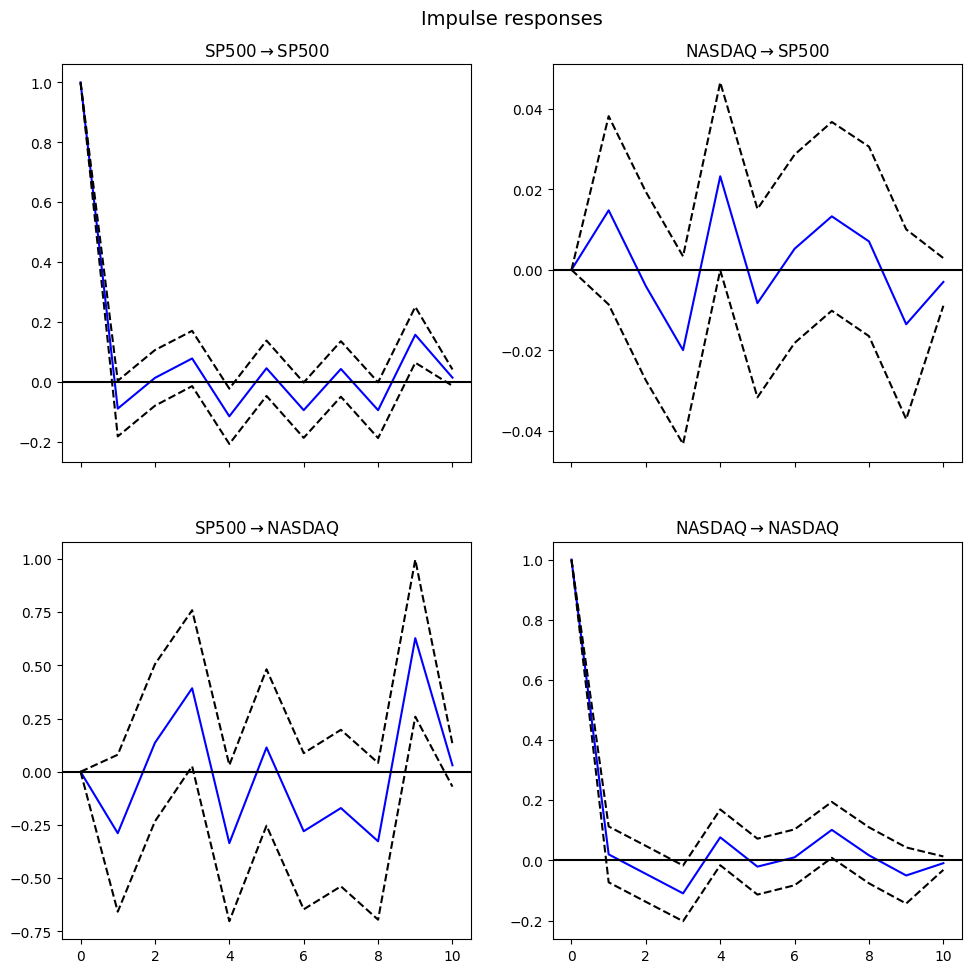

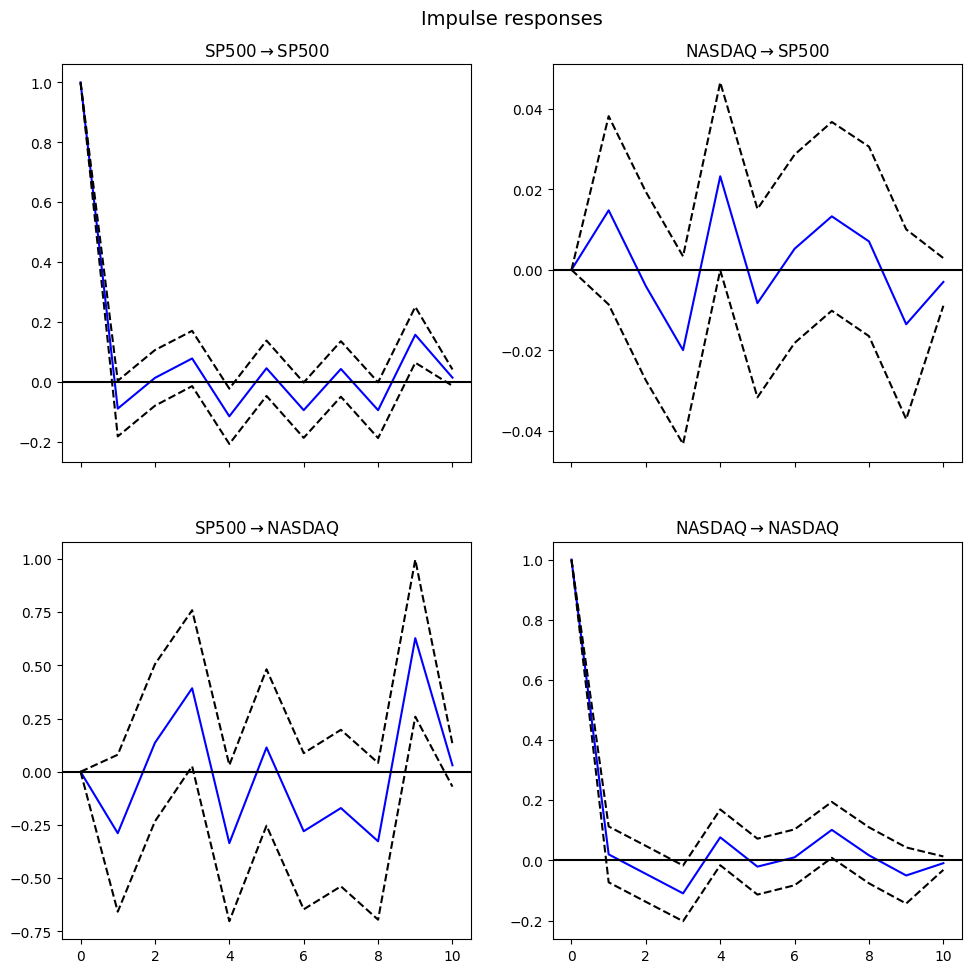

In [13]:
# Fitting the Vector Error correction model to find the short term relationship between the two series

data = pd.DataFrame({
    'SP500': sp500['Diff_Log_Close_SP500'].dropna(),
    'NASDAQ': nq100['Diff_Log_Close_NQ100'].dropna()
}).dropna()

# Selecting the optimal lag length
lag_order = select_order(data, maxlags=15, deterministic='ci')
print(lag_order.summary())

# Determining the number of cointegrating relations
coint_rank = select_coint_rank(data, det_order=0, k_ar_diff=lag_order.aic)
print(coint_rank.summary())

# Fitting the VECM model
vecm = VECM(data, k_ar_diff=lag_order.aic, coint_rank=coint_rank.rank, deterministic='ci')
vecm_fit = vecm.fit() 
print(vecm_fit.summary())

# Accessing the alpha, beta, and gamma matrices
alpha = vecm_fit.alpha
beta = vecm_fit.beta
gamma = vecm_fit.gamma

print("Alpha matrix:\n", alpha)
print("Beta matrix:\n", beta)
print("Gamma matrix:\n", gamma)

# Plotting Impulse Response Functions
irf = vecm_fit.irf(periods=10)
irf.plot(orth=False)






In [14]:
# Calculation for kalman filter (Hedge ratio)
# Initial parameters
R = 1e-5  # Process noise
Q = 1e-5  # Measurement noise
beta = np.zeros(len(data))  # Initial estimate of beta
P = np.zeros(len(data))  # Initial estimate of the covariance

# Initial values
beta[0] = 0
P[0] = 1


In [15]:
kalman_gain = np.zeros(len(data))

for t in range(1, len(data)):
    # Prediction step
    P[t] = P[t-1] + R
    
    # Kalman gain
    kalman_gain[t] = P[t] * data['SP500'].iloc[t] / (data['SP500'].iloc[t]**2 * P[t] + Q)
    
    # Update step
    beta[t] = beta[t-1] + kalman_gain[t] * (data['NASDAQ'].iloc[t] - data['SP500'].iloc[t] * beta[t-1])
    
    # Update the covariance matrix
    P[t] = (1 - kalman_gain[t] * data['SP500'].iloc[t]) * P[t]

# Adding beta to the Dataframe
data['beta'] = beta


In [16]:
# Calculate the spread
spread = data['NASDAQ'] - beta * data['SP500']

# Adding the spread to Dataframe for further calculation
data['spread'] = data['NASDAQ'] - data['beta'] * data['SP500']

# Normalizing the spread
normalized_spread = (spread - spread.mean()) / spread.std()

# Generating trading signals
signals = np.where(normalized_spread > 1, -1, 0)  # Sell signal
signals = np.where(normalized_spread < -1, 1, signals)  # Buy signal

data['signals'] = signals


Total Cumulative Return: 483.75
Annualized Return: 19.30%


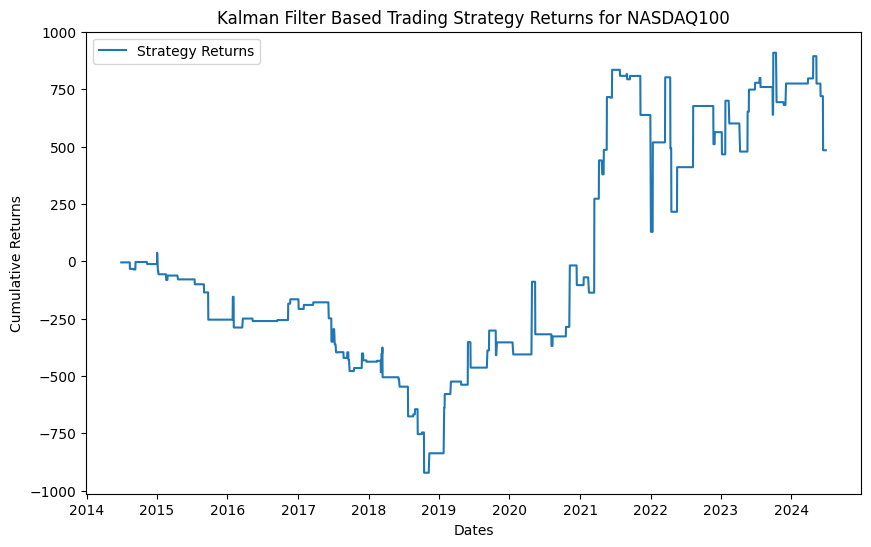

In [17]:
# Calculating returns for NASDAQ only strategy (Single Index model)
data['returns_NASDAQ'] = data['NASDAQ'].shift(-1) * data['signals']

# Filling any NaN values that might result from shifting
data['returns_NASDAQ'].fillna(0, inplace=True)

# Calculating cumulative returns
data['cumulative_returns_NASDAQ'] = data['returns_NASDAQ'].cumsum()

total_cumulative_return = data['cumulative_returns_NASDAQ'].iloc[-1]

print(f"Total Cumulative Return: {total_cumulative_return}")

# Annualized return for NASDAQ100
cumulative_return =  total_cumulative_return/ 100  # Convert percentage to decimal

# Number of years
years = 10

# Calculating the annualized return
annual_return = (1 + cumulative_return) ** (1 / years) - 1

print(f"Annualized Return: {annual_return * 100:.2f}%")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(data['cumulative_returns_NASDAQ'], label='Strategy Returns')
plt.title('Kalman Filter Based Trading Strategy Returns for NASDAQ100')
plt.xlabel('Dates')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


Total Cumulative Return: 101.96273596946673
Annualized Return: 7.28%


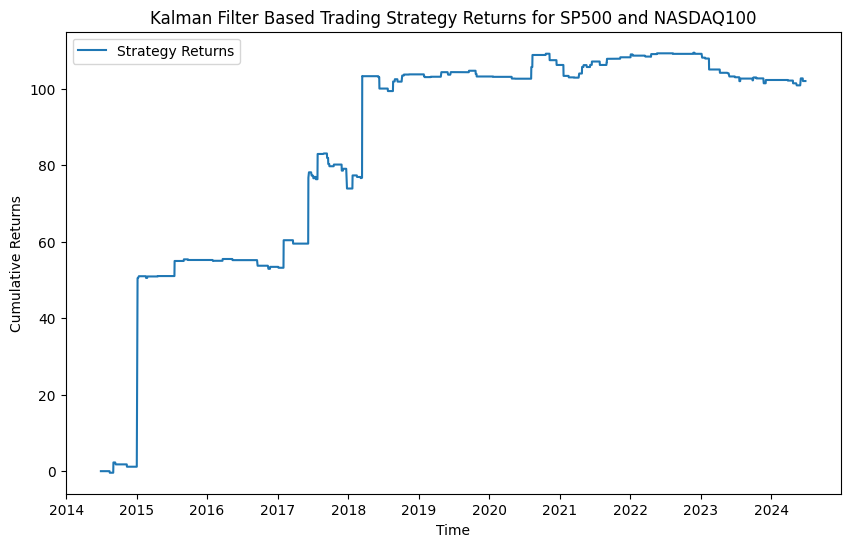

In [18]:
# Calculating returns for both SP500 and NASDAQ100 i.e pairs trading strategy
data['returns'] = data['signals'].shift(1) * (data['NASDAQ'] - data['beta'] * data['SP500'])

# Filling any NaN values that might result from shifting
data['returns'].fillna(0, inplace=True)

# Calculating cumulative returns
data['cumulative_returns'] = data['returns'].cumsum()

total_cumulative_return = data['cumulative_returns'].iloc[-1]

print(f"Total Cumulative Return: {total_cumulative_return}")

# Annualized return for NASDAQ100 and SP500 
cumulative_return = total_cumulative_return / 100  # Convert percentage to decimal

# Number of years
years = 10

# Calculate the annualized return
annual_return = (1 + cumulative_return) ** (1 / years) - 1

print(f"Annualized Return: {annual_return * 100:.2f}%")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data['cumulative_returns'], label='Strategy Returns')
plt.title('Kalman Filter Based Trading Strategy Returns for SP500 and NASDAQ100')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

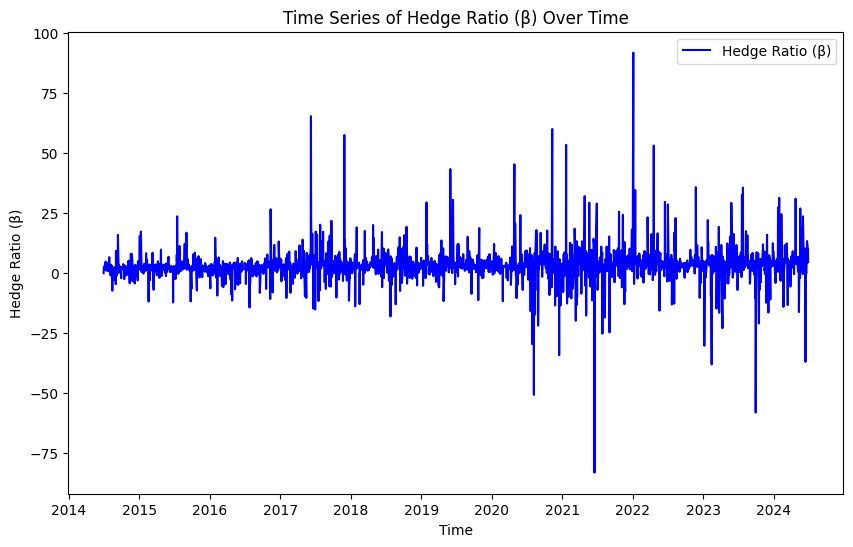

In [19]:
# Plotting the hedge ratio over time
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['beta'], label='Hedge Ratio (β)', color='blue')

# Adding titles and labels
plt.title('Time Series of Hedge Ratio (β) Over Time')
plt.xlabel('Time')
plt.ylabel('Hedge Ratio (β)')
plt.legend()

# Display the plot
plt.show()

In [20]:
# Calcualation of the performance metrics for comparing both the strategy's results.

# Code for calculating performance of E-mini futures SP500 and NASDAQ100 pairs trading.

# 1. Maximum Drawdown
def calculate_max_drawdown(cumulative_returns):
    drawdown = cumulative_returns - cumulative_returns.cummax()
    max_drawdown = drawdown.min()
    return max_drawdown

# 2. Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.05):
    excess_returns = returns - risk_free_rate / 252  # Assuming daily returns and annual risk-free rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)  # Annualize the Sharpe Ratio
    return sharpe_ratio_annualized


# 3. Volatility (Standard Deviation of Returns)
def calculate_volatility(returns):
    volatility = np.std(returns) * np.sqrt(252)  # Annualized volatility
    return volatility

# 4. Recovery Time from Drawdown
def calculate_recovery_time(cumulative_returns):
    drawdown_end = np.argmax(np.maximum.accumulate(cumulative_returns) - cumulative_returns)  # end of the drawdown
    drawdown_start = np.argmax(cumulative_returns[:drawdown_end])  # start of the drawdown
    recovery_time = drawdown_end - drawdown_start
    return recovery_time

# 5. Number of Trades Executed
def calculate_number_of_trades(signals):
    num_trades = np.count_nonzero(signals)
    return num_trades

# 6. Average Holding Period per Trade
def calculate_average_holding_period(signals):
    holding_periods = []
    current_holding = 0
    for signal in signals:
        if signal != 0:  # When a trade signal occurs
            if current_holding > 0:
                holding_periods.append(current_holding)
            current_holding = 0
        current_holding += 1
    average_holding_period = np.mean(holding_periods)
    return average_holding_period


# Example of how to apply these functions
max_drawdown = calculate_max_drawdown(data['cumulative_returns'])
sharpe_ratio = calculate_sharpe_ratio(data['returns'])
volatility = calculate_volatility(data['returns'])
recovery_time = calculate_recovery_time(data['cumulative_returns'])
num_trades = calculate_number_of_trades(data['signals'])
average_holding_period = calculate_average_holding_period(data['signals'])

print(f"Maximum Drawdown: {max_drawdown}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Volatility: {volatility}")
print(f"Recovery Time from Drawdown: {recovery_time} days")
print(f"Number of Trades Executed: {num_trades}")
print(f"Average Holding Period per Trade: {average_holding_period} days")



Maximum Drawdown: -9.162382422182304
Sharpe Ratio: 0.5279778907114104
Volatility: 19.171360388061085
Recovery Time from Drawdown: 83 days
Number of Trades Executed: 114
Average Holding Period per Trade: 22.265486725663717 days


In [21]:
# Code for Calculating performance of NASDAQ100 only strategy.
max_drawdown = calculate_max_drawdown(data['cumulative_returns_NASDAQ'])
sharpe_ratio = calculate_sharpe_ratio(data['returns_NASDAQ'])
volatility = calculate_volatility(data['returns_NASDAQ'])
recovery_time = calculate_recovery_time(data['cumulative_returns_NASDAQ'])
num_trades = calculate_number_of_trades(data['signals'])
average_holding_period = calculate_average_holding_period(data['signals'])

print(f"Maximum Drawdown: {max_drawdown}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Volatility: {volatility}")
print(f"Recovery Time from Drawdown: {recovery_time} days")
print(f"Number of Trades Executed: {num_trades}")
print(f"Average Holding Period per Trade: {average_holding_period} days")

Maximum Drawdown: -958.5
Sharpe Ratio: 0.10721745416960435
Volatility: 449.64782446349034
Recovery Time from Drawdown: 960 days
Number of Trades Executed: 114
Average Holding Period per Trade: 22.265486725663717 days


In [22]:
# Calculating the correlation between the hedge ratio (beta) and the strategy returns 
correlation_beta_returns = data['beta'].corr(data['returns'])
correlation_beta_returns_NASDAQ =data['beta'].corr(data['returns_NASDAQ'])

print(f"Correlation between Hedge Ratio (Beta) and SP500 and NASDAQ100 Strategy Returns: {correlation_beta_returns}")
print(f'Correlation between Hedge Retio  (Beta) and  NASDAQ100 only:{correlation_beta_returns_NASDAQ}')


Correlation between Hedge Ratio (Beta) and SP500 and NASDAQ100 Strategy Returns: 0.03541766990935154
Correlation between Hedge Retio  (Beta) and  NASDAQ100 only:0.0569769675589003


In [23]:
# Calculating the standard deviation of the hedge ratio (beta)
beta_volatility = data['beta'].std()

print(f"Volatility (Standard Deviation) of Hedge Ratio (Beta): {beta_volatility}")


Volatility (Standard Deviation) of Hedge Ratio (Beta): 6.8086431407167725


In [24]:
# Code for Sensitivity Analysis for different betas

def run_kalman_filter(data, R, Q):
    n = len(data)
    beta = np.zeros(n)
    P = np.zeros(n)
    kalman_gain = np.zeros(n)
    
    beta[0] = 0
    P[0] = 1
    
    for t in range(1, n):
        P[t] = P[t-1] + R
        kalman_gain[t] = P[t] * data['SP500'].iloc[t] / (data['SP500'].iloc[t]**2 * P[t] + Q)
        beta[t] = beta[t-1] + kalman_gain[t] * (data['NASDAQ'].iloc[t] - beta[t-1] * data['SP500'].iloc[t])
        P[t] = (1 - kalman_gain[t] * data['SP500'].iloc[t]) * P[t]
    
    data['beta'] = beta
    return beta

# Running sensitivity analysis with different R and Q values
R_values = [1e-5, 1e-4, 1e-3]
Q_values = [1e-5, 1e-4, 1e-3]

for R in R_values:
    for Q in Q_values:
        beta_sensitivity = run_kalman_filter(data, R, Q)
        beta_volatility = np.std(beta_sensitivity)
        print(f"R: {R}, Q: {Q} -> Volatility of Beta: {beta_volatility}")


R: 1e-05, Q: 1e-05 -> Volatility of Beta: 6.80729529488733
R: 1e-05, Q: 0.0001 -> Volatility of Beta: 3.766685976468283
R: 1e-05, Q: 0.001 -> Volatility of Beta: 2.1966392280523226
R: 0.0001, Q: 1e-05 -> Volatility of Beta: 12.462287762095423
R: 0.0001, Q: 0.0001 -> Volatility of Beta: 6.807295297649247
R: 0.0001, Q: 0.001 -> Volatility of Beta: 3.766686027808831
R: 0.001, Q: 1e-05 -> Volatility of Beta: 18.053529207595805
R: 0.001, Q: 0.0001 -> Volatility of Beta: 12.462287763484015
R: 0.001, Q: 0.001 -> Volatility of Beta: 6.80729532524439


Percentage of Aligned Signals with Significant Beta Changes: 83.33%


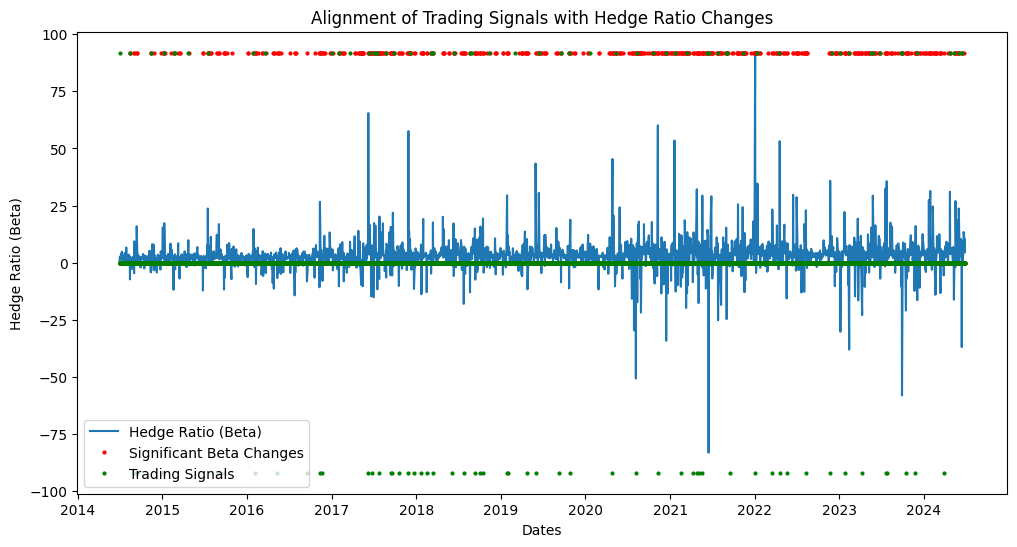

In [25]:
# Calculating  the percentage of time when signals align with significant changes in beta
significant_changes_in_beta = np.where(np.abs(data['beta'].diff()) > beta_volatility, 1, 0)
aligned_signals = np.sum((significant_changes_in_beta == 1) & (data['signals'] != 0)) / np.sum(data['signals'] != 0)

print(f"Percentage of Aligned Signals with Significant Beta Changes: {aligned_signals * 100:.2f}%")

# Visualizing this alignment
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['beta'], label='Hedge Ratio (Beta)')
plt.plot(data.index, significant_changes_in_beta * data['beta'].max(), 'ro', markersize=2, label='Significant Beta Changes')
plt.plot(data.index, data['signals'] * data['beta'].max(), 'go', markersize=2, label='Trading Signals')
plt.title('Alignment of Trading Signals with Hedge Ratio Changes')
plt.xlabel('Dates')
plt.ylabel('Hedge Ratio (Beta)')
plt.legend()
plt.show()


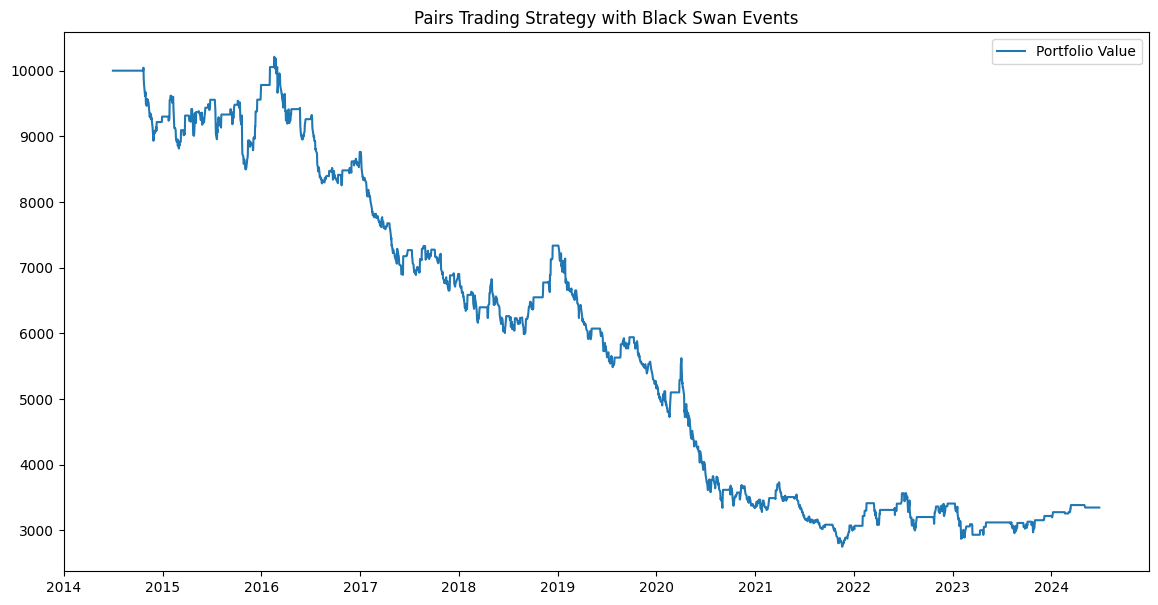

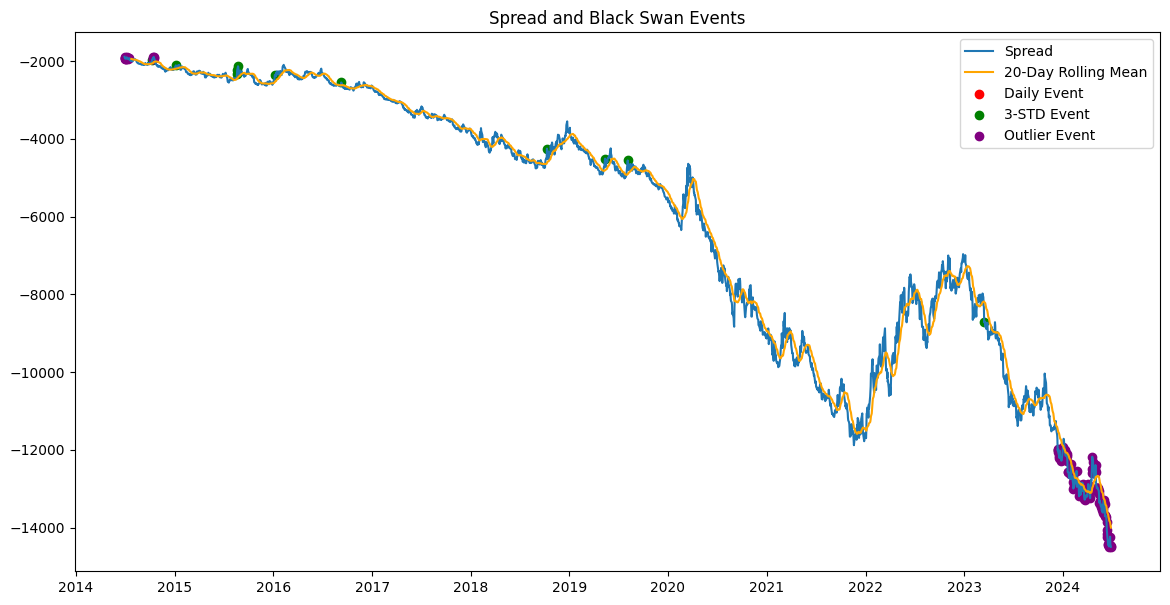

Total Daily Events: 0
Total 3-STD Events: 12
Total Outlier Events: 127


In [26]:
# Code for Black Swan trading strategy
#Step 1: Calculating the spread between SP500 and NASDAQ100
data['Close_SP500'] = sp500['Close']
data['Close_nq']=nq100['Close']
data['Spread'] = data['Close_SP500'] - data['Close_nq']

# Parameters
N_percent = 10  # N% for Daily Events
K_day = 20  # K-day rolling mean
contamination = 0.05  # Contamination for IsolationForest

# Step 1: Calculating rolling mean and standard deviation
data['Spread_Mean'] = data['Spread'].rolling(window=K_day).mean()
data['Spread_STD'] = data['Spread'].rolling(window=K_day).std()

# Step 2: Identifying Daily Events (N% from K-day rolling mean)
data['Daily_Event'] = np.abs(data['Spread'] - data['Spread_Mean']) / data['Spread_Mean'] > N_percent / 100

# Step 3: Identifying 3-STD Events
data['3STD_Event'] = np.abs(data['Spread'] - data['Spread_Mean']) > 3 * data['Spread_STD']

# Step 4: Identifying  Outlier Events using IsolationForest
iso_forest = IsolationForest(contamination=contamination, random_state=42)
data['Outlier_Event'] = iso_forest.fit_predict(data[['Spread']])
data['Outlier_Event'] = data['Outlier_Event'] == -1  # Mark outliers as True

# Step 5: Generating Trading Signals
def generate_signals(data):
    data['Signal'] = 0
    
    # Long Signal (Buy)
    data.loc[(data['Daily_Event'] | data['3STD_Event'] | data['Outlier_Event']) & (data['Spread'] < data['Spread_Mean']), 'Signal'] = 1
    
    # Short Signal (Sell)
    data.loc[(data['Daily_Event'] | data['3STD_Event'] | data['Outlier_Event']) & (data['Spread'] > data['Spread_Mean']), 'Signal'] = -1
    
    # Closing the trades
    data['Signal'] = data['Signal'].replace(0, np.nan).ffill().fillna(0)
    data['Signal'][(data['Spread'] * data['Signal']) < data['Spread_Mean'] * data['Signal']] = 0

    return data

data = generate_signals(data)

# Step 6: Backtesting the Strategy
def backtest_strategy(data, initial_capital=10000):
    data['Position'] = data['Signal'].shift(1)
    data['Strategy_Return_Black'] = data['Position'] * data['Spread'].pct_change()
    data['Portfolio_Value'] = initial_capital * (1 + data['Strategy_Return_Black']).cumprod()
    
    return data

data = backtest_strategy(data)

# Plotting results
plt.figure(figsize=(14, 7))
plt.plot(data['Portfolio_Value'], label='Portfolio Value')
plt.title('Pairs Trading Strategy with Black Swan Events')
plt.legend()
plt.show()

# Plotting the Black Swan Events on the Spread
plt.figure(figsize=(14, 7))
plt.plot(data['Spread'], label='Spread')
plt.plot(data['Spread_Mean'], label=f'{K_day}-Day Rolling Mean', color='orange')
plt.scatter(data.index[data['Daily_Event']], data['Spread'][data['Daily_Event']], color='red', label='Daily Event')
plt.scatter(data.index[data['3STD_Event']], data['Spread'][data['3STD_Event']], color='green', label='3-STD Event')
plt.scatter(data.index[data['Outlier_Event']], data['Spread'][data['Outlier_Event']], color='purple', label='Outlier Event')
plt.title('Spread and Black Swan Events')
plt.legend()
plt.show()

# Counting the total number of each type of event
total_daily_events = data['Daily_Event'].sum()
total_3std_events = data['3STD_Event'].sum()
total_outlier_events = data['Outlier_Event'].sum()

# Printing the results
print(f"Total Daily Events: {total_daily_events}")
print(f"Total 3-STD Events: {total_3std_events}")
print(f"Total Outlier Events: {total_outlier_events}")



In [27]:
# Calculating the performance metrics for Black Swan trading strategy

# Define evaluation function
def evaluate_strategy(data, initial_capital=10000):
    # Calculating total return
    total_return = data['Portfolio_Value'].iloc[-1] - initial_capital
    
    # Calculate Sharpe Ratio
    sharpe_ratio = data['Strategy_Return_Black'].mean() / data['Strategy_Return_Black'].std()
    
    # Calculating Calmar Ratio
    max_drawdown = data['Portfolio_Value'].cummax() - data['Portfolio_Value']
    calmar_ratio = data['Strategy_Return_Black'].mean() / max_drawdown.max()
    
    # Calculating Win/Loss Ratio
    win_loss_ratio = len(data[data['Strategy_Return_Black'] > 0]) / len(data[data['Strategy_Return_Black'] < 0])
    
    return total_return, sharpe_ratio, calmar_ratio, win_loss_ratio

# Applying  the evaluation function to get the metrics
total_return, sharpe_ratio, calmar_ratio, win_loss_ratio = evaluate_strategy(data)

# Creating  a DataFrame to display the results
performance_metrics = pd.DataFrame({
    'Performance Metric': ['Total Return', 'Sharpe Ratio', 'Calmar Ratio', 'Win/Loss Ratio'],
    'Value': [total_return, sharpe_ratio, calmar_ratio, win_loss_ratio]
})

# Displaying the performance metrics table
performance_metrics

,Performance Metric,Value
0,Total Return,-6.653701e+03
1,Sharpe Ratio,-4.170183e-02
2,Calmar Ratio,-5.222816e-08
3,Win/Loss Ratio,8.204134e-01


100%|██████████| 500/500 [00:40<00:00, 12.50trial/s, best loss: 7290.356198776379]
Best Parameters:  {'N_percent': 49.979700658172355, 'contamination': 0.1584871223930475, 'stop_loss': 0.22438324643210256}
Bollinger Bands Strategy - Total Return: -5148.2658061646825, Sharpe Ratio: -0.010654726067510901, Calmar Ratio: -0.6277179096669249, Win/Loss Ratio: 0.9935535858178888


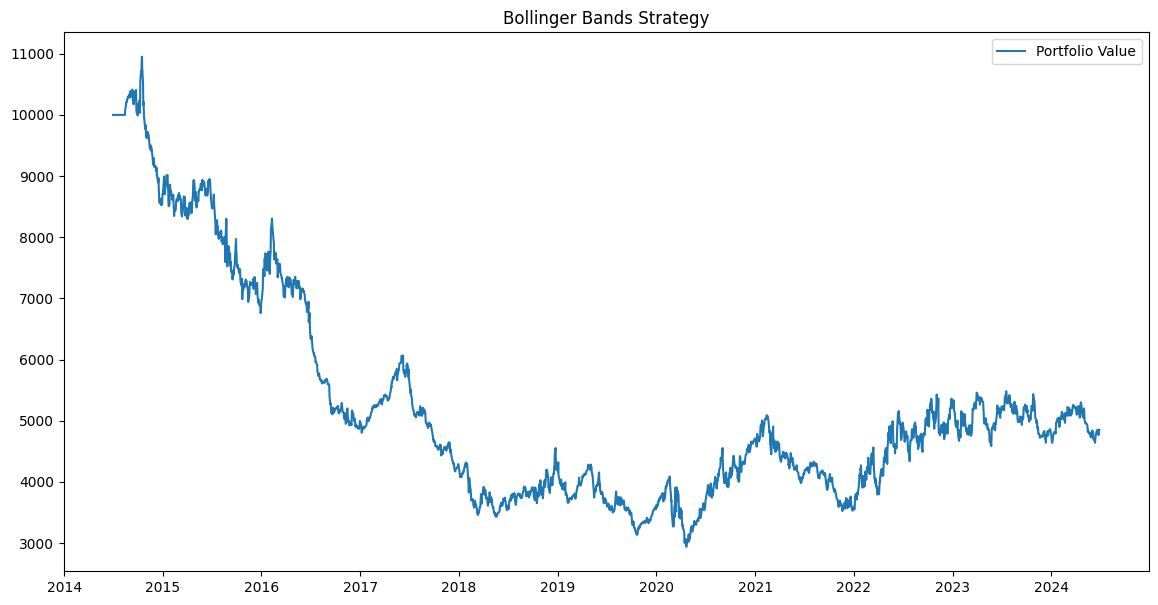

In [28]:
# Calculating Bollinger Bands Strategy
# Step 2: Calculate spread
data['Spread'] = data['Close_SP500'] - data['Close_nq']

data['Spread_Mean'] = data['Spread'].rolling(window=20).mean()
data['Spread_STD'] = data['Spread'].rolling(window=20).std()

# Step 2:Black Swan Events
def detect_black_swan_events(data, N_percent, contamination):
    data['Daily_Event'] = (np.abs(data['Spread'] - data['Spread_Mean']) / data['Spread_Mean']) > N_percent / 100
    data['3STD_Event'] = np.abs(data['Spread'] - data['Spread_Mean']) > 3 * data['Spread_STD']
    
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    data['Outlier_Event'] = iso_forest.fit_predict(data[['Spread']])
    data['Outlier_Event'] = data['Outlier_Event'] == -1  # Mark outliers as True
    
    return data

# Step 3: Trading Strategies
def apply_strategy(data, stop_loss):
    data['Signal'] = 0
    data['Signal'][(data['Daily_Event'] | data['3STD_Event'] | data['Outlier_Event']) & (data['Spread'] < data['Spread_Mean'])] = 1
    data['Signal'][(data['Daily_Event'] | data['3STD_Event'] | data['Outlier_Event']) & (data['Spread'] > data['Spread_Mean'])] = -1
    
    data['Signal'] = data['Signal'].replace(0, np.nan).ffill().fillna(0)
    
    # Applying stop-loss
    data['Signal'][(data['Spread'] * data['Signal']) < -stop_loss * data['Spread_STD']] = 0
    
    return data

# Step 4: Evaluation Metrics
def evaluate_strategy(data, initial_capital=10000):
    data['Position'] = data['Signal'].shift(1)
    data['Strategy_Returns'] = data['Position'] * data['Spread'].pct_change()
    data['Portfolio_Value_Bollinger'] = initial_capital * (1 + data['Strategy_Returns']).cumprod()
    
    total_return = data['Portfolio_Value_Bollinger'].iloc[-1] - initial_capital
    sharpe_ratio = data['Strategy_Returns'].mean() / data['Strategy_Returns'].std()
    max_drawdown = (data['Portfolio_Value_Bollinger'].cummax() - data['Portfolio_Value']).max()
    calmar_ratio = total_return / max_drawdown
    win_loss_ratio = len(data['Strategy_Returns'][data['Strategy_Returns'] > 0]) / len(data['Strategy_Returns'][data['Strategy_Returns'] < 0])
    
    return total_return, sharpe_ratio, calmar_ratio, win_loss_ratio

# Step 5: Bayesian Optimization of Strategy Hyperparameters
def objective(params,data):
    N_percent = params['N_percent']
    stop_loss = params['stop_loss']
    contamination = params['contamination']
    data_copy = data.copy() 
    
    # Detect Black Swan Events
    data = detect_black_swan_events(data_copy, N_percent=N_percent, contamination=contamination)
    
    # Applying the Strategy
    data_copy = apply_strategy(data, stop_loss=stop_loss)
    
    # Evaluating the Strategy
    total_return, sharpe_ratio, calmar_ratio, win_loss_ratio = evaluate_strategy(data)
    
    return {'loss': -total_return, 'status': STATUS_OK}

# Defining the parameter space for optimization
space = {
    'N_percent': hp.uniform('N_percent', 5, 50),
    'stop_loss': hp.uniform('stop_loss', 0.0, 0.6),
    'contamination': hp.uniform('contamination', 0.01, 0.2)
}

# Running the optimization
trials = Trials()
best = fmin(fn=lambda params: objective(params,data), space=space, algo=tpe.suggest, max_evals=500, trials=trials)

# Print the best parameters
print("Best Parameters: ", best)

# Step 6: Backtest and Compare Against Bollinger Bands Strategy
# Defining  and evaluating Bollinger Bands strategy
def bollinger_bands_strategy(data, BB_mean, BB_std):
    data['Upper_Band'] = data['Spread_Mean'] + BB_std * data['Spread_STD']
    data['Lower_Band'] = data['Spread_Mean'] - BB_std * data['Spread_STD']
    
    data['Signal'] = 0
    data.loc[data['Spread'] > data['Upper_Band'], 'Signal'] = -1
    data.loc[data['Spread'] < data['Lower_Band'], 'Signal'] = 1
    
    data['Signal'] = data['Signal'].replace(0, np.nan).ffill().fillna(0)
    
    return data

#  evaluation on Bollinger Bands strategy
data = bollinger_bands_strategy(data, BB_mean=20, BB_std=2)
total_return, sharpe_ratio, calmar_ratio, win_loss_ratio = evaluate_strategy(data)

print(f"Bollinger Bands Strategy - Total Return: {total_return}, Sharpe Ratio: {sharpe_ratio}, Calmar Ratio: {calmar_ratio}, Win/Loss Ratio: {win_loss_ratio}")

# Plot for portfolio value
plt.figure(figsize=(14, 7))
plt.plot(data['Portfolio_Value_Bollinger'], label='Portfolio Value')
plt.title('Bollinger Bands Strategy')
plt.legend()
plt.show()



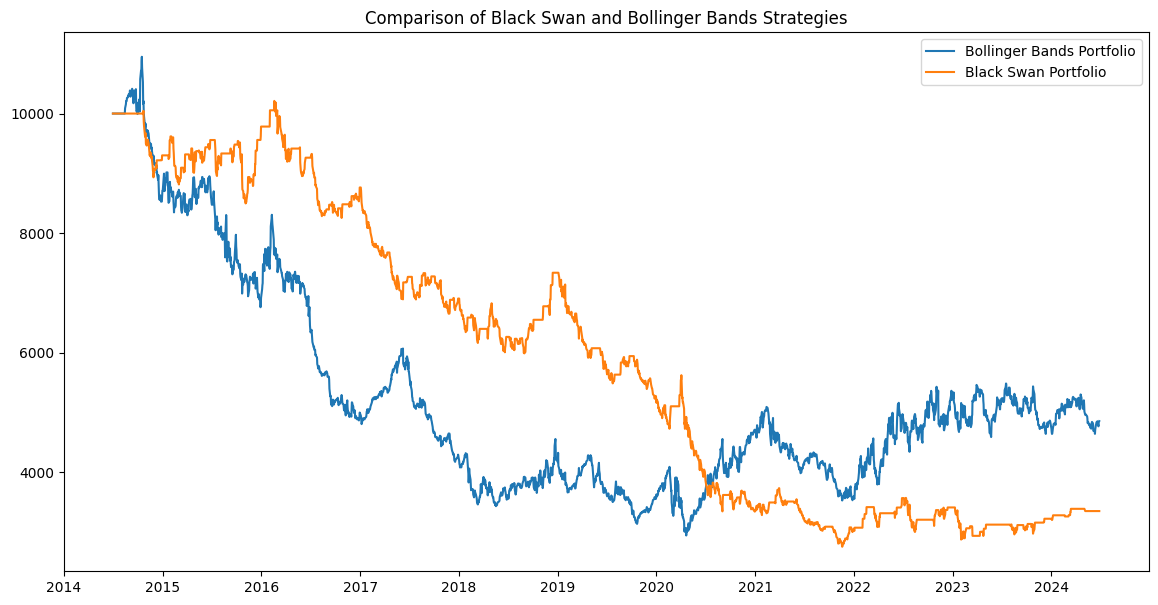

In [29]:
# Step 7: Plot and Compare Strategies
# Comparing Black Swan returns with Bollinger Bands trading strategy returns.
plt.figure(figsize=(14, 7))
plt.plot(data['Portfolio_Value_Bollinger'], label='Bollinger Bands Portfolio')
plt.plot(data['Portfolio_Value'], label='Black Swan Portfolio')  # Plot for Black Swan
plt.title('Comparison of Black Swan and Bollinger Bands Strategies')
plt.legend()
plt.show()

In [30]:
from sklearn.ensemble import IsolationForest
# 
# Step 2: Black Swan Events
def detect_black_swan_events(data, asset_mean, break_event=None, contamination=None):
    # Daily Black Swans
    if break_event is not None:
        data['Daily_Event'] = (np.abs(data['Spread'] - data['Spread_Mean']) / data['Spread_Mean']) > break_event
    
    # 3-STD Black Swans
    data['3STD_Event'] = np.abs(data['Spread'] - data['Spread_Mean']) > 3 * data['Spread_STD']
    
    # Outliers Black Swans
    if contamination is not None:
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        data['Outlier_Event'] = iso_forest.fit_predict(data[['Spread']])
        data['Outlier_Event'] = data['Outlier_Event'] == -1  # Mark outliers as True
    
    return data



In [31]:
# Step 3: Trading Strategies
def apply_black_swan_strategy(data, strategy_type, asset_mean, break_event=None, contamination=None, stop_loss=None):
    data = detect_black_swan_events(data, asset_mean, break_event, contamination)
    
    data['Signal'] = 0
    if strategy_type == 'Daily':
        data['Signal'][(data['Daily_Event']) & (data['Spread'] < data['Spread_Mean'])] = 1
        data['Signal'][(data['Daily_Event']) & (data['Spread'] > data['Spread_Mean'])] = -1
    
    elif strategy_type == '3STD':
        data['Signal'][(data['3STD_Event']) & (data['Spread'] < data['Spread_Mean'])] = 1
        data['Signal'][(data['3STD_Event']) & (data['Spread'] > data['Spread_Mean'])] = -1
    
    elif strategy_type == 'Outliers':
        data['Signal'][(data['Outlier_Event']) & (data['Spread'] < data['Spread_Mean'])] = 1
        data['Signal'][(data['Outlier_Event']) & (data['Spread'] > data['Spread_Mean'])] = -1
    
    data['Signal'] = data['Signal'].replace(0, np.nan).ffill().fillna(0)
    
    # Applying stop-loss
    if stop_loss is not None:
        data['Signal'][(data['Spread'] * data['Signal']) < -stop_loss * data['Spread_STD']] = 0
    
    return data


In [32]:
def evaluate_strategy(data, initial_capital=10000):
    data['Position'] = data['Signal'].shift(1)
    data['Strategy_Returns'] = data['Position'] * data['Spread'].pct_change()
    data['Portfolio_Value_Bollinger'] = initial_capital * (1 + data['Strategy_Returns']).cumprod()
    
    total_return = data['Portfolio_Value_Bollinger'].iloc[-1] - initial_capital
    sharpe_ratio = data['Strategy_Returns'].mean() / data['Strategy_Returns'].std()
    
    # Fix for ZeroDivisionError: Handle cases where there are no losing trades
    if len(data['Strategy_Returns'][data['Strategy_Returns'] < 0]) == 0:
        win_loss_ratio = np.inf  # or you could set it to a large number or a specific value like 0
    else:
        win_loss_ratio = len(data['Strategy_Returns'][data['Strategy_Returns'] > 0]) / len(data['Strategy_Returns'][data['Strategy_Returns'] < 0])
    
    max_drawdown = (data['Portfolio_Value_Bollinger'].cummax() - data['Portfolio_Value_Bollinger']).max()
    
    if max_drawdown != 0:
        calmar_ratio = total_return / max_drawdown
    else:
        calmar_ratio = np.nan  # or set it to a specific value if max_drawdown is zero
    
    return total_return, sharpe_ratio, calmar_ratio, win_loss_ratio


In [33]:
# Daily Black Swans Strategy
data_daily = apply_black_swan_strategy(data.copy(), strategy_type='Daily', asset_mean=5, break_event=0.1)
total_return_daily, sharpe_ratio_daily, calmar_ratio_daily, win_loss_ratio_daily = evaluate_strategy(data_daily)

# 3-STD Black Swans Strategy
data_3std = apply_black_swan_strategy(data.copy(), strategy_type='3STD', asset_mean=20)
total_return_3std, sharpe_ratio_3std, calmar_ratio_3std, win_loss_ratio_3std = evaluate_strategy(data_3std)

# Outliers Black Swans Strategy
data_outliers = apply_black_swan_strategy(data.copy(), strategy_type='Outliers', asset_mean=200, contamination=0.1)
total_return_outliers, sharpe_ratio_outliers, calmar_ratio_outliers, win_loss_ratio_outliers = evaluate_strategy(data_outliers)

# Print the results
print(f"Daily Black Swans Strategy - Total Return: {total_return_daily}, Sharpe Ratio: {sharpe_ratio_daily}, Calmar Ratio: {calmar_ratio_daily}, Win/Loss Ratio: {win_loss_ratio_daily}")
print(f"3-STD Black Swans Strategy - Total Return: {total_return_3std}, Sharpe Ratio: {sharpe_ratio_3std}, Calmar Ratio: {calmar_ratio_3std}, Win/Loss Ratio: {win_loss_ratio_3std}")
print(f"Outliers Black Swans Strategy - Total Return: {total_return_outliers}, Sharpe Ratio: {sharpe_ratio_outliers}, Calmar Ratio: {calmar_ratio_outliers}, Win/Loss Ratio: {win_loss_ratio_outliers}")


Daily Black Swans Strategy - Total Return: 0.0, Sharpe Ratio: nan, Calmar Ratio: nan, Win/Loss Ratio: inf
3-STD Black Swans Strategy - Total Return: -7868.321109467677, Sharpe Ratio: -0.03183440819500045, Calmar Ratio: -0.8505213537117583, Win/Loss Ratio: 0.8495440729483282
Outliers Black Swans Strategy - Total Return: -8584.516821460775, Sharpe Ratio: -0.04202620613612003, Calmar Ratio: -0.945699038261343, Win/Loss Ratio: 0.9065134099616858


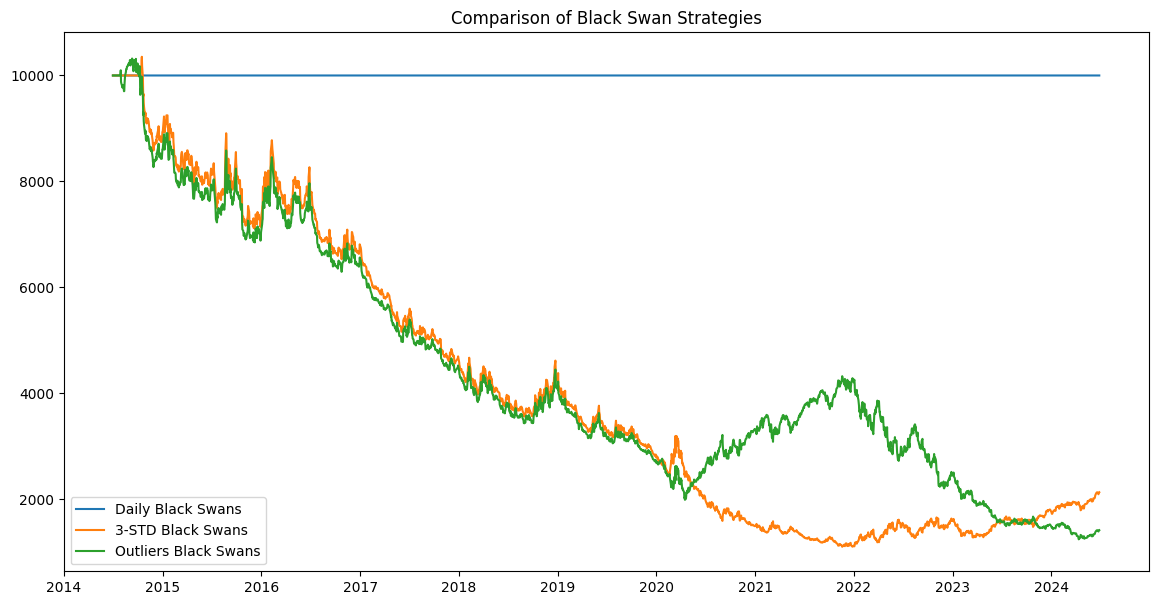

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(data_daily['Portfolio_Value_Bollinger'], label='Daily Black Swans')
plt.plot(data_3std['Portfolio_Value_Bollinger'], label='3-STD Black Swans')
plt.plot(data_outliers['Portfolio_Value_Bollinger'], label='Outliers Black Swans')
plt.title('Comparison of Black Swan Strategies')
plt.legend()
plt.show()
